This jupyter notebook goes through a workflow to compare predicted lineaments with field validated or mapped lineaments. Lineaments are linear features on the Earth's surface that often reflect underlying structural controls such as faults, fractures, or lithologic boundaries. They can be identified from remote sensing data (e.g., DEMs or satellite imagery) and are important for understanding geological structures, groundwater flow paths, and areas of enhanced permeability, especially in karst or fractured-rock environments.


In [8]:
## Imports
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import LineString, MultiLineString
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from LineAccuracyAssessment import *



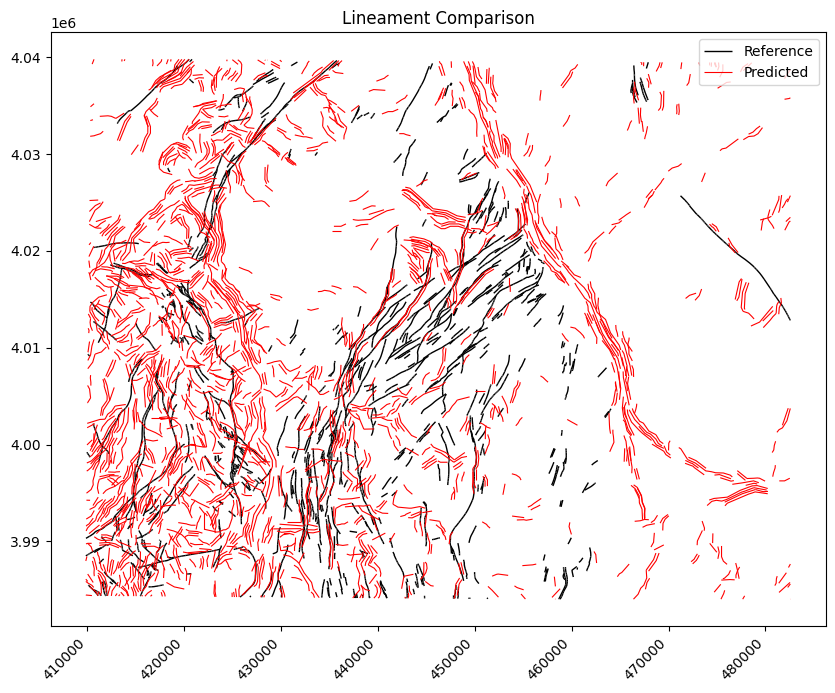

In [ ]:
# Specify paths to shapefiles for comparison 
REF_LINES_PATH = r'C:\Users\rl587\Documents\Lineaments_python\Lineament_shapefiles\TubaCity50k_faults.shp' # known mapped lineaments
PRED_LINES_PATH = r'C:\Users\rl587\Documents\Lineaments_python\Lineament_shapefiles\AZ_30m_lineament_TubaCity.shp' # lineaments extracted from DEMs


###  Step 1: Load the shapfiles
- Load the shapefiles
- clip to the same extent (extent of smaller shapefile)

In [ ]:

ref_lines, pred_lines = load_and_plot_lineaments(REF_LINES_PATH, PRED_LINES_PATH)

### Step 2: Total Length Comparison

**Function:** `compare_lineament_lengths(ref_lines, pred_lines)`

- **What it does** calculate and compare the total length (in meters) of reference and predicted lineaments
- **Why it matters** it provides a first look at over or under detection. large discrepencies may indicate systemic bias or failure to accuratly predict or delineate lineaments
- **Metrics** Total length per dataset; predicted-to-reference length ratio


**Method:**
- Each line feature is assumed to be in a projected coordinate system (e.g., UTM) where Euclidean distance is meaningful.

- The total length is computed using shapely.length across all features.

- A ratio of predicted to reference length is reported.

**Interpretation:**
- A ratio close to 1 indicates overall similarity in feature abundance.

- Large ratios (≫1 or ≪1) may indicate over-segmentation, missed detections, or noise.

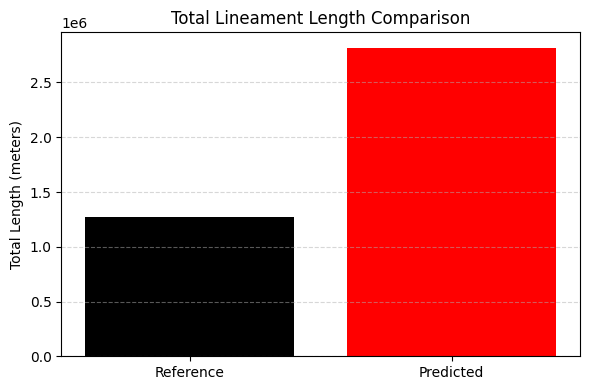

{'ref_total_length_m': np.float64(1270423.4150079386), 'pred_total_length_m': np.float64(2817225.5799199203), 'length_ratio': np.float64(2.2175485327482853)}


In [10]:
length_stats = compare_lineament_lengths(ref_lines, pred_lines)
print(length_stats)

### Step 3: Orientaton Comparison 

**Function:** `plot_orientation_comparison(ref_lines, pred_lines)`

- **What it does** Computes the azimuth (0–180°) of each lineament and visualizes the distribution with:
    * Side-by-side orientation histograms
    * Rose diagrams for structural trend comparison
- **Why it matters** Assesses whether the predicted lineaments capture the dominant structural orientations present in the reference data.
- **Metrics**  Visual comparison; can be extended with circular statistics.

**Method:**
- Each line’s orientation is calculated using the azimuth from its first to last coordinate, mapped to [0°, 180°] to account for line symmetry.

- In case of MultiLineString, the longest component is used.

*Two visualizations are generated:*

- A histogram of azimuths (using equal-width bins, e.g., 10°)

- A rose diagram (polar histogram), where angles are doubled to account for bidirectionality (180° symmetry)

**Interpretation:**

- Alignment in peaks indicates structural consistency.

- Divergence suggests the model is misinterpreting regional tectonic patterns.

**Optional next steps:** Add circular statistical tests (e.g., Kuiper, Watson-Williams) for quantification.

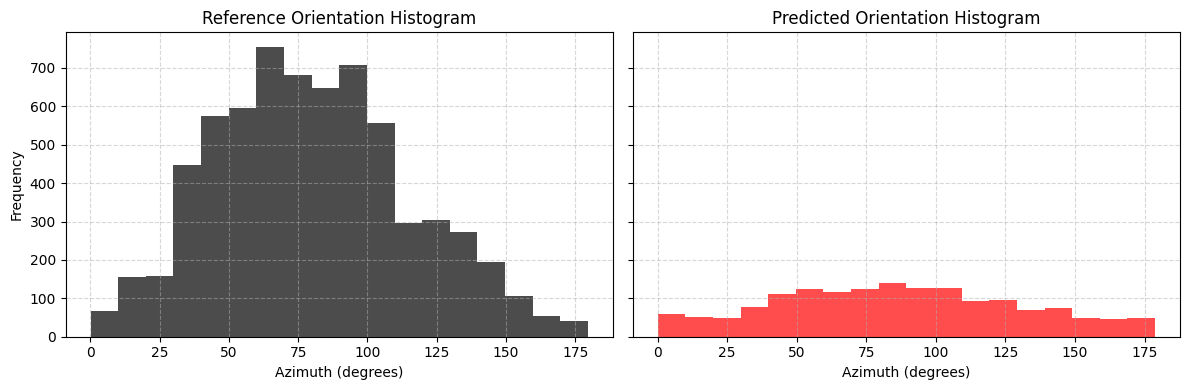

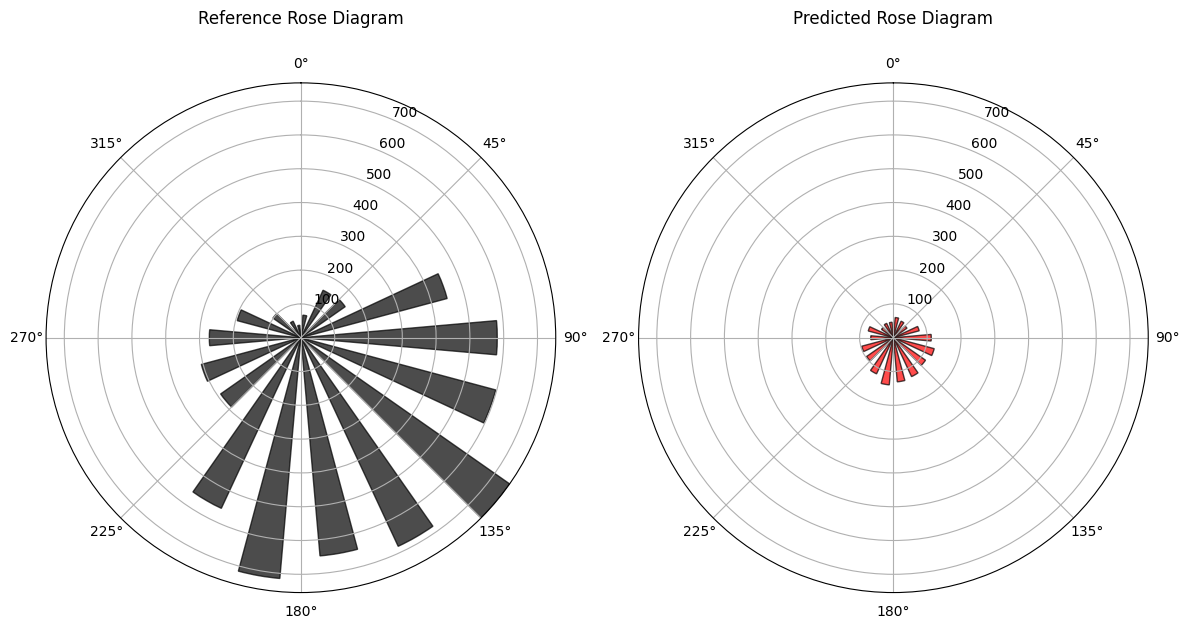

In [ ]:
plot_orientation_comparison(ref_lines, pred_lines)




### Step 4: Buffer-based Spatial Overlap (Precision, Recall, F1)

**Function:** `compute_buffer_overlap_metrics(ref_lines, pred_lines, buffer_distance=50, highlight_fp_fn=True)`

- **What it does**  Buffers reference lineaments (e.g., by 50 m) and measures:
    * How much of the predicted line length overlaps the buffer (precision)
    * How much of the reference line length is captured by predictions (recall)
    * Combines both into F1 Score
    * Optionally highlights false positives (FPs) and false negatives (FNs) on the map
- **Why it matters** A commonly used, interpretable method to quantify positional agreement between two line networks.
- **Metrics**  Precision, Recall, F1 Score; TP, FP, FN lengths and percentages.

**Method:** 

1. **Buffering:**
    * Reference lineaments are buffered (e.g., 50 meters) to create a spatial tolerance zone.
2. **Overlap Metrics:**

    - A predicted line is considered a True Positive (TP) if it intersects the buffer.

    - A False Positive (FP) if it does not intersect any reference buffer.

    - A False Negative (FN) is a reference line that is not intersected by any predicted buffer.

3. **Length-based Confusion matrix:**

    - TP, FP, and FN are measured in total line length, not count.

    - Precision = TP / (TP + FP)

    - Recall = TP / (TP + FN)

    - F1 = harmonic mean of precision and recall

4. **Visualizations**

    - Map showing all predicted and reference lines

    - Optionally highlights FP (e.g., orange) and FN (e.g., blue) segments

    - Confusion matrix and metrics printed beside the plot

**Interpretation:**

    * High precision + recall → strong spatial match

    * High FP → overprediction or noise

    * High FN → important structures missed

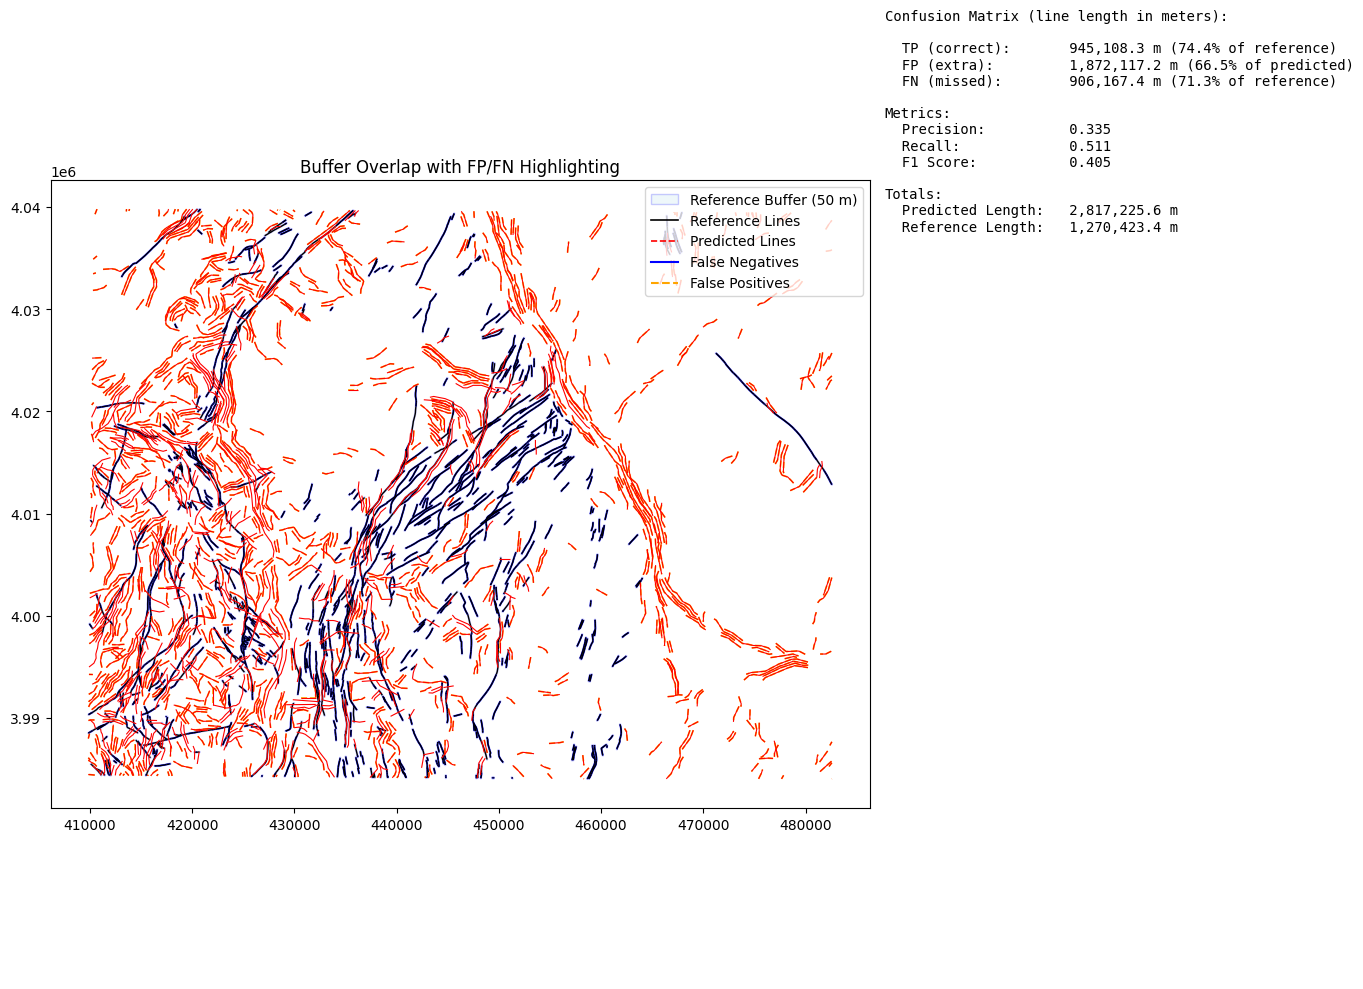

In [12]:
#metrics = compute_buffer_overlap_metrics(ref_lines, pred_lines, buffer_distance=50)
metrics = compute_buffer_overlap_metrics(ref_lines, pred_lines, buffer_distance=50, highlight_fp_fn=True)



### Step 5: Lineament Density Comparison

**Function:** `compare_lineament_density(ref_lines, pred_lines, cell_size=1000)`

- **What it does**  Divides the study area into a regular grid (e.g. 30m2 or 1 km2 cells) and calculates:
    * The density of lineaments (km/km²) in each cell for both datasets
    * Visual comparison of spatial patterns
    * Statistical comparison using RMSE and Pearson correlation
- **Why it matters** Evaluates the spatial distribution of lineaments, testing whether predicted features occur in the same areas and with similar intensity as the reference.
- **Metrics** Cell-wise density maps; RMSE; Pearson correlation (r)


**Method:**

**1. Grid Generation:**

    - The shared bounding box of the datasets is divided into regular square cells (e.g., 1 km × 1 km).

**2. Line Intersections:**

- For each cell, lineaments are clipped to the grid cell boundary.

- The total line length (in kilometers) in each cell is computed.

- Density = length (km) / area (km²)

**3.Comparison Metrics:**

    - Root Mean Square Error (RMSE): Measures average error in predicted vs. reference density per cell.

    - Pearson’s r: Measures correlation in spatial patterns (i.e., are high-density regions matched?).

**Interpretation:**

    - High r (close to 1) → predicted density follows true spatial trends

    - Low RMSE → magnitude of density differences is small

    - High RMSE + low r → overprediction + misalignment of patterns

**Use Case:**
Essential when ground truth data is sparse, or when using statistical or machine-learning lineament extraction, where direct one-to-one line matching isn't meaningful.


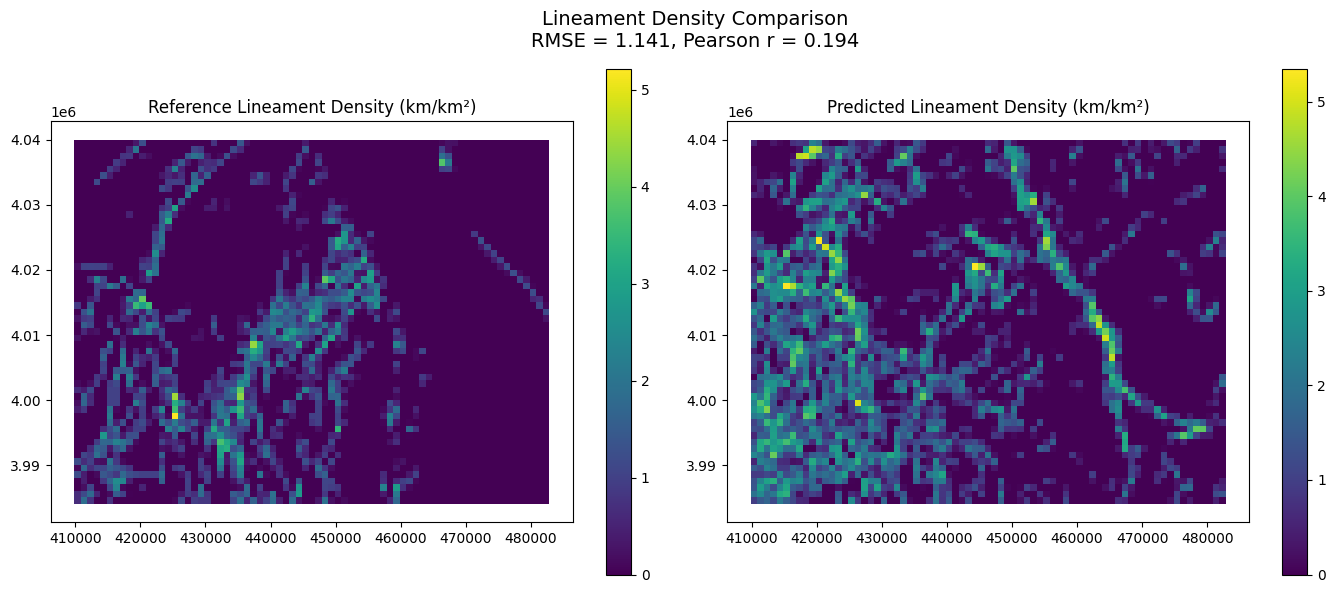

{'rmse': np.float64(1.140979168295635), 'pearson_r': np.float64(0.19396125064231698)}


In [13]:
grid_df, density_stats = compare_lineament_density(ref_lines, pred_lines, cell_size=1000)
print(density_stats)